In [1]:
# 1. Import thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam, Adamax, Ftrl

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel('btc_processed_data.xlsx')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(time_step, 1)))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100, return_sequences=True))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(1))  # Output layer
model.compile(optimizer = Ftrl(learning_rate = 0.001, l1_regularization_strength=0.0, l2_regularization_strength=0.0), loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 100)          30900     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 gru_1 (GRU)                 (None, 100, 100)          60600     
                                                                 
 dropout_1 (Dropout)         (None, 100, 100)          0         
                                                                 
 gru_2 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 11s 117ms/step - loss: 0.1794 - val_loss: 0.0676
Epoch 2/100
17/17 [==============================] - 0s 22ms/step - loss: 0.1782 - val_loss: 0.0659
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.1763 - val_loss: 0.0646
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 0.1748 - val_loss: 0.0636
Epoch 5/100
17/17 [==============================] - 0s 17ms/step - loss: 0.1735 - val_loss: 0.0626
Epoch 6/100
17/17 [==============================] - 0s 17ms/step - loss: 0.1724 - val_loss: 0.0618
Epoch 7/100
17/17 [==============================] - 0s 17ms/step - loss: 0.1714 - val_loss: 0.0610
Epoch 8/100
17/17 [==============================] - 0s 16ms/step - loss: 0.1704 - val_loss: 0.0603
Epoch 9/100
17/17 [==============================] - 0s 17ms/step - loss: 0.1695 - val_loss: 0.0597
Epoch 10/100
17/17 [==============================] - 0s 16ms/step - loss: 0.1687 - val_loss: 0.05

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

9/9 [==============================] - 0s 6ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
valid_rmse = np.sqrt(mean_squared_error(yval, y_pred_val))
test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

# Calculate MSE
valid_mse = mean_squared_error(yval, y_pred_val)
test_mse = mean_squared_error(ytest, y_pred)

# Calculate MAE
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

# Calculate MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Validation RMSE: {valid_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Validation MSE: {valid_mse}")
print(f"Testing MSE: {test_mse}")
print(f"Validation MAE: {valid_mae}")
print(f"Testing MAE: {test_mae}")
print(f"Validation MAPE: {valid_mape}%")
print(f"Testing MAPE: {test_mape}%")

Validation RMSE: 9324.668582555232
Testing RMSE: 9325.026310187224
Validation MSE: 86949444.17449261
Testing MSE: 86956115.68568397
Validation MAE: 9324.668579908062
Testing MAE: 9325.026310001933
Validation MAPE: 1736643.7504943616%
Testing MAPE: 3769891.212977254%


## Dự báo cho 30 ngày

In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.68583501 0.67756889 0.68967404 0.69201294 0.73224787 0.76921984
 0.84739737 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461
 0.86609866 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915
 0.98615743 0.97688739 1.         0.97566562 0.9469183  0.88793761
 0.93230318 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499
 0.86986376 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542
 0.95397313 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056
 0.93400854 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905
 0.96399961 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929
 0.8662525  0.82968151 0.86193771 0.86670989 0.88331172 0.88233372
 0.90990125 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873
 0.85617441 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184
 0.8674009  0.86941556 0.8568772  0.84494544 0.82840125 0.85526172
 0.82270083 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604
 0.88673257 0.91299111 0.91138888 0.90183292 0.9764

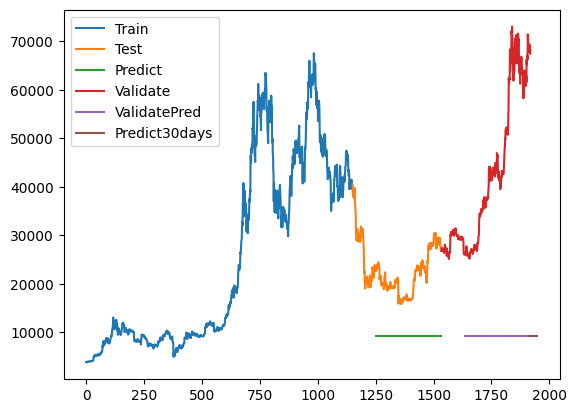

In [14]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## Dự báo cho 60 ngày

In [15]:
# 13. Dự báo 60 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.68583501 0.67756889 0.68967404 0.69201294 0.73224787 0.76921984
 0.84739737 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461
 0.86609866 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915
 0.98615743 0.97688739 1.         0.97566562 0.9469183  0.88793761
 0.93230318 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499
 0.86986376 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542
 0.95397313 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056
 0.93400854 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905
 0.96399961 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929
 0.8662525  0.82968151 0.86193771 0.86670989 0.88331172 0.88233372
 0.90990125 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873
 0.85617441 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184
 0.8674009  0.86941556 0.8568772  0.84494544 0.82840125 0.85526172
 0.82270083 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604
 0.88673257 0.91299111 0.91138888 0.90183292 0.9764

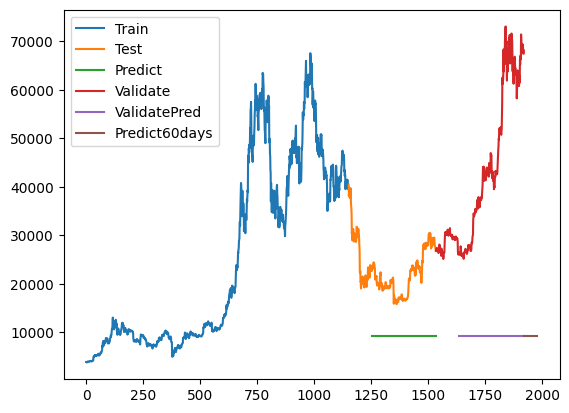

In [16]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict60days'])
plt.show()

## Dự báo cho 90 ngày

In [17]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.68583501 0.67756889 0.68967404 0.69201294 0.73224787 0.76921984
 0.84739737 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461
 0.86609866 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915
 0.98615743 0.97688739 1.         0.97566562 0.9469183  0.88793761
 0.93230318 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499
 0.86986376 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542
 0.95397313 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056
 0.93400854 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905
 0.96399961 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929
 0.8662525  0.82968151 0.86193771 0.86670989 0.88331172 0.88233372
 0.90990125 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873
 0.85617441 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184
 0.8674009  0.86941556 0.8568772  0.84494544 0.82840125 0.85526172
 0.82270083 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604
 0.88673257 0.91299111 0.91138888 0.90183292 0.9764

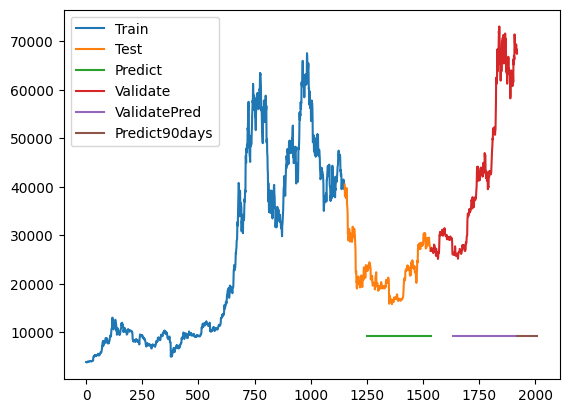

In [19]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict90days'])
plt.show()